In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy import stats
import analysis_perDRG
import scikit_posthocs as sp

In [2]:
name = 'd7perDRG_'

with open('D7_SNI_area.json') as f:
    results_sni = json.load(f)
with open('D7_Sham_area.json') as f:
    results_sham = json.load(f)

In [3]:
sham_il = analysis_perDRG.GroupData(results_sham, 'IL', number_of_rats=6)
sham_cl = analysis_perDRG.GroupData(results_sham, 'CL', number_of_rats=6)

sni_il = analysis_perDRG.GroupData(results_sni, 'IL', number_of_rats=6)
sni_cl = analysis_perDRG.GroupData(results_sni, 'CL', number_of_rats=6)

In [4]:
def plot_all(feature, ylabel):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)      
    #statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(12,8))
    
    labels=['Sham IL', 'Sham CL', 'SNI IL', 'SNI CL']

    c='k'
    alpha=1
    standard_props = {"color":c, "alpha":alpha, "linewidth":5}
    markers= ['D','o']
    line_props = standard_props
    bbox_props = {**standard_props, 'facecolor': 'w', 'edgecolor':c} #dict(edgecolor=c, alpha=alpha, linewidth=5, facecolor='w')
    median_props = standard_props
    cap_props = standard_props
    linewidth = 5
    fontsize = 32
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.tick_params(length=10, width=linewidth)
    if 'tissue area' in ylabel:
        ax.set_ylim([-1, 10.2])
    elif 'Neurons/' in ylabel:
        ax.set_ylim([-1, 400])
    elif 'normalized intensities' in ylabel:
        ax.set_ylim([-0.1, 1.01])
    elif 'intensities' in ylabel:
        ax.set_ylim([-1,4000])
    elif 'GFAP integrated' in ylabel:
        ax.set_ylim([-1,250000000])
    elif 'GS integrated' in ylabel:
        ax.set_ylim([-1,800000000])
    else:
        ax.set_ylim([-1, 101])
    plt.xticks(fontname="Arial", fontsize=fontsize)
    plt.yticks(fontname="Arial", fontsize=fontsize)


    plt.ylabel(ylabel, fontname="Arial", fontsize=34)

    

    sns.boxplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], width=0.5, whiskerprops=line_props, boxprops=bbox_props
                ,capprops=cap_props, medianprops=median_props, fliersize=0)
    sns.stripplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], jitter=0.2, dodge=True, size=8, marker='o', palette='tab20')
    
    ax.set_xticklabels(labels, fontname="Arial", fontsize=34)
    
    plt.savefig('D7 Boxplots/'+name+feature+'.png', bbox_inches = "tight")
    plt.show()

In [5]:
def statistic_all(feature):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)
    
    # Test for normal distribution
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    statistic, p_value_c = stats.shapiro(group_c_data)
    statistic, p_value_d = stats.shapiro(group_d_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05) or (p_value_c < 0.05) or (p_value_d < 0.05):
        # data is not normally distrubuted (<0.05)
        # non-parametric version of ANOVA
        statistic, p_value = stats.kruskal(group_a_data, group_b_data, group_c_data, group_d_data, nan_policy='omit')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
        #perform posthoc mannwhitney-u
        stat = sp.posthoc_mannwhitney([pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna()])
        
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            # tests the equality of k independent means in the face of heterogeneity of variance
            statistic, p_value = stats.alexandergovern([group_a_data, group_b_data, group_c_data, group_d_data], nan_policy='omit')
            print('Welch’s t-test: p-value='+"{:.5f}".format(p_value))
 
        else: 
            #data is normally distributed and have equal variances
            equal_variance = True
            statistic, p_value = stats.f_oneway(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
            print('one-way ANOVA: p-value='+"{:.5f}".format(p_value))
        stat = sp.posthoc_ttest([pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna()], equal_var=equal_variance) 
    
    
    stat.columns = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    stat.index = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    return stat.round(4)

In [6]:
def quick_plot(group_a, group_b, feature):
    group_a_data = getattr(group_a, feature)
    group_b_data = getattr(group_b, feature)    
    
    statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(4,6))
    sns.boxplot(data=[group_a_data, group_b_data])
    sns.stripplot(data=[group_a_data, group_b_data], jitter=0.2)
    ax = plt.gca()
    ax.set_xticklabels([group_a.name, group_b.name], fontsize=16)
    plt.ylabel(feature, fontsize=16)
    plt.show()

In [7]:
def statistic(group_a_data, group_b_data):
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05):
        # data is not normally distrubuted (<0.05)
        statistic, p_value = stats.mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(group_a_data, group_b_data)
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            print('Welch-test')
        else: 
            equal_variance = True
            print('t-test')
        # perform t-test
        statistic, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=equal_variance, nan_policy='omit')
        print('p-value='+"{:.5f}".format(p_value))

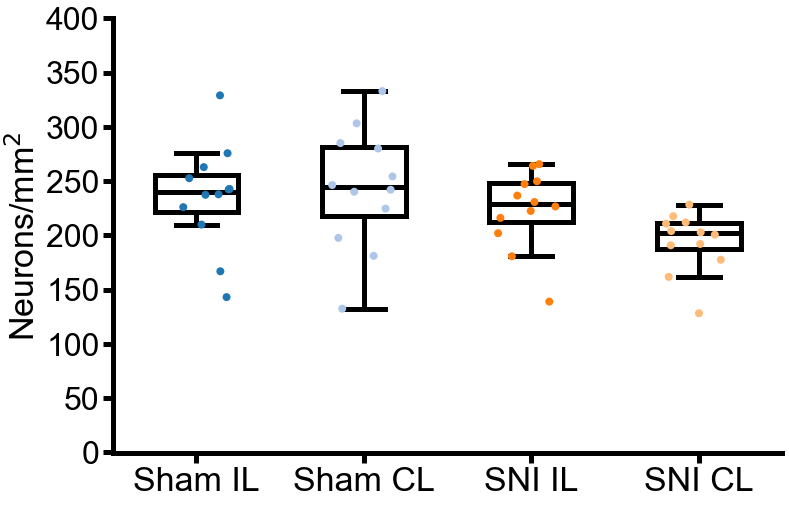

In [8]:
plot_all('neurons_per_tissue', 'Neurons/mm$^2$')

In [9]:
statistic_all('neurons_per_tissue')

one-way ANOVA: p-value=0.03815


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7153,0.4930,0.0161
Sham_CL,0.7153,1.0000,0.3065,0.0108
SNI_IL,0.4930,0.3065,1.0000,0.0342
SNI_CL,0.0161,0.0108,0.0342,1.0000


### GFAP rings > 0

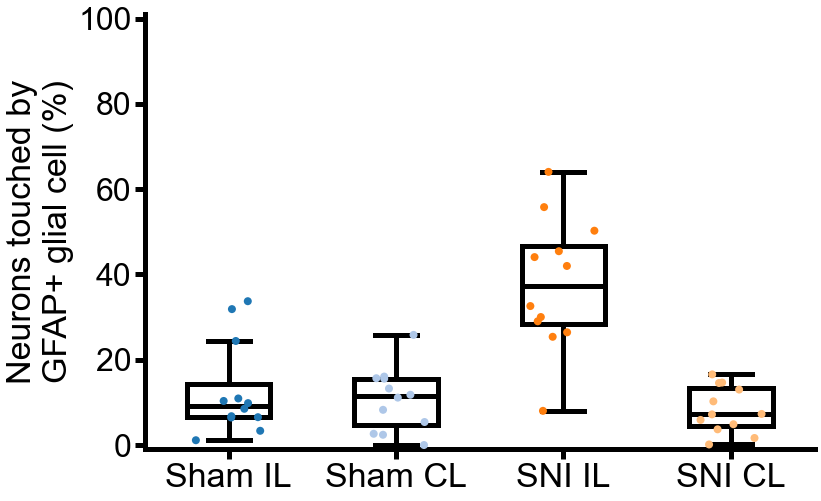

In [10]:
plot_all('ring_ratios_gfap', 'Neurons touched by\nGFAP+ glial cell (%)')

In [12]:
statistic_all('ring_ratios_gfap')

Mann Whitney U: p-value=0.00016


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9770,0.0014,0.5067
Sham_CL,0.9770,1.0000,0.0003,0.4705
SNI_IL,0.0014,0.0003,1.0000,0.0001
SNI_CL,0.5067,0.4705,0.0001,1.0000


### GS rings > 0

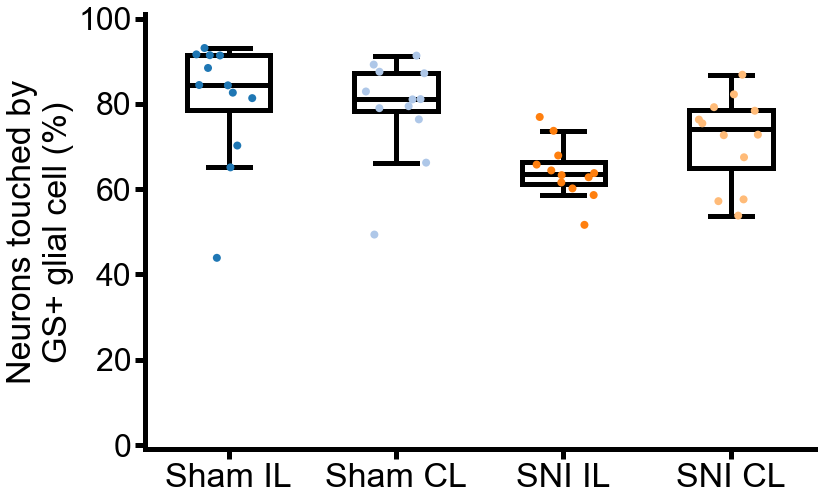

In [13]:
plot_all('ring_ratios_gs', 'Neurons touched by\nGS+ glial cell (%)')

In [14]:
statistic_all('ring_ratios_gs')

Mann Whitney U: p-value=0.00079


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.2855,0.0020,0.0304
Sham_CL,0.2855,1.0000,0.0014,0.0351
SNI_IL,0.0020,0.0014,1.0000,0.0885
SNI_CL,0.0304,0.0351,0.0885,1.0000


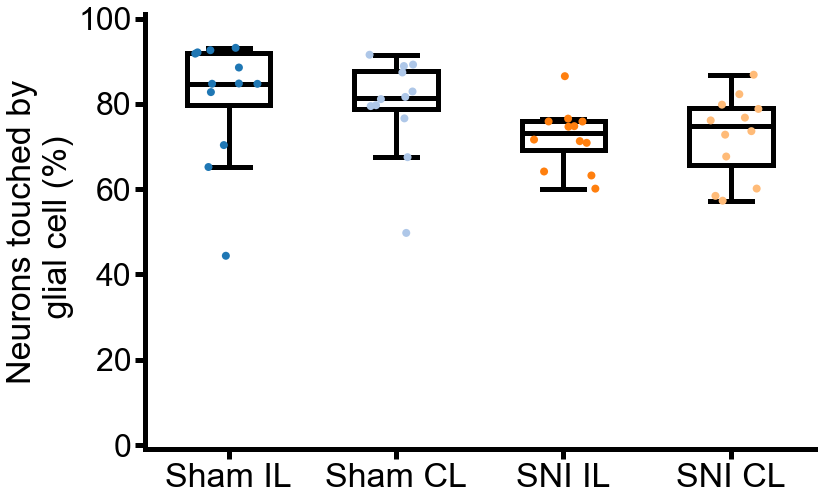

In [15]:
plot_all('ring_ratios_ring', 'Neurons touched by\n glial cell (%)')

In [16]:
statistic_all('ring_ratios_ring')

Mann Whitney U: p-value=0.01217


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.2855,0.0304,0.0262
Sham_CL,0.2855,1.0000,0.0102,0.0464
SNI_IL,0.0304,0.0102,1.0000,0.5834
SNI_CL,0.0262,0.0464,0.5834,1.0000


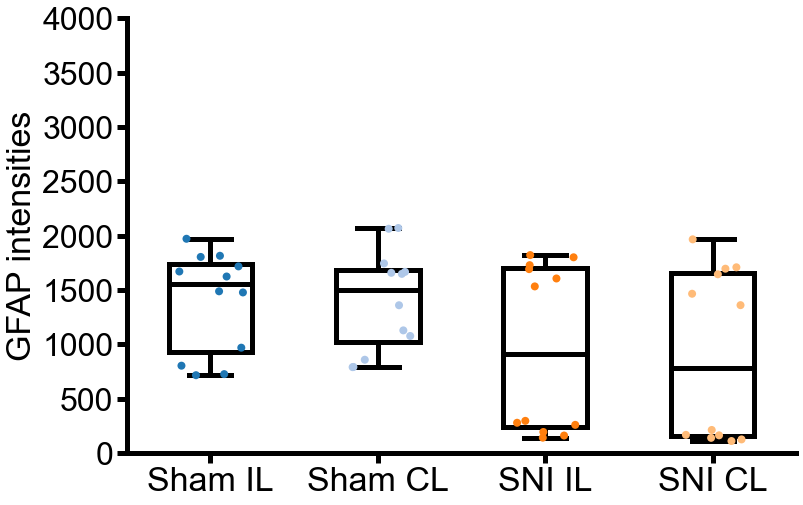

In [17]:
plot_all('gfap_intensities', 'GFAP intensities')

In [18]:
statistic_all('gfap_intensities')

Mann Whitney U: p-value=0.19542


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9770,0.1939,0.0885
Sham_CL,0.9770,1.0000,0.2145,0.1410
SNI_IL,0.1939,0.2145,1.0000,0.4025
SNI_CL,0.0885,0.1410,0.4025,1.0000


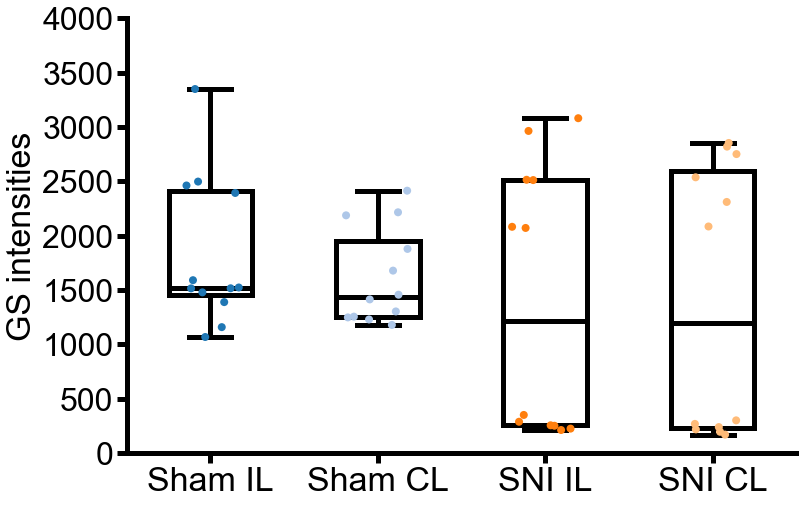

In [19]:
plot_all('gs_intensities', 'GS intensities')

In [20]:
statistic_all('gs_intensities')

Mann Whitney U: p-value=0.82284


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.4025,0.5067,0.5067
Sham_CL,0.4025,1.0000,0.7508,0.8399
SNI_IL,0.5067,0.7508,1.0000,0.8399
SNI_CL,0.5067,0.8399,0.8399,1.0000


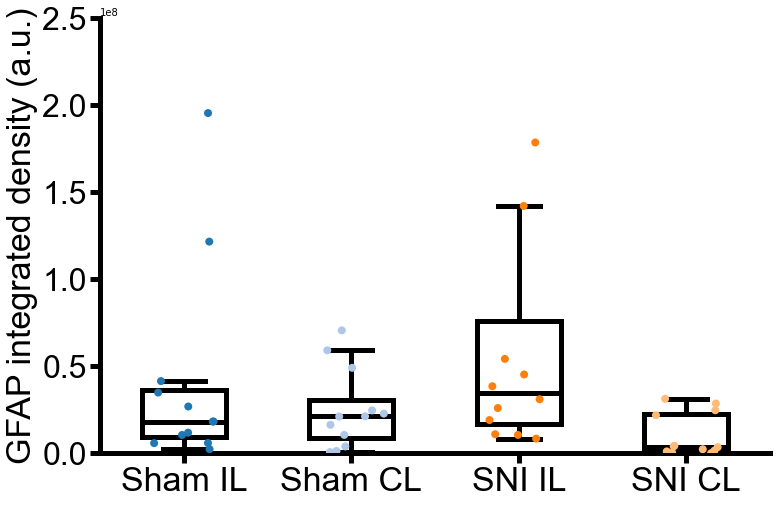

In [21]:
plot_all('gfap_integrated_density', 'GFAP integrated density (a.u.)')

In [22]:
statistic_all('gfap_integrated_density')

Mann Whitney U: p-value=0.01543


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8399,0.1749,0.0262
Sham_CL,0.8399,1.0000,0.1572,0.1572
SNI_IL,0.1749,0.1572,1.0000,0.0024
SNI_CL,0.0262,0.1572,0.0024,1.0000


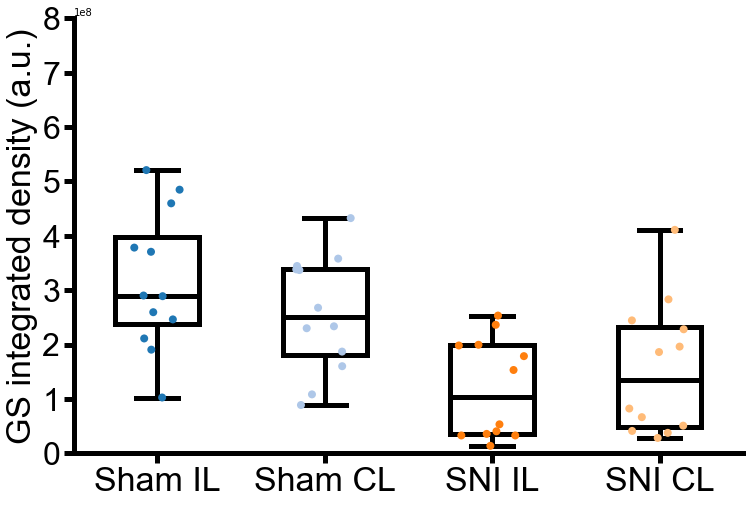

In [23]:
plot_all('gs_integrated_density', 'GS integrated density (a.u.)')

In [24]:
statistic_all('gs_integrated_density')

Mann Whitney U: p-value=0.00065


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.2366,0.0007,0.0051
Sham_CL,0.2366,1.0000,0.0073,0.0351
SNI_IL,0.0007,0.0073,1.0000,0.3708
SNI_CL,0.0051,0.0351,0.3708,1.0000


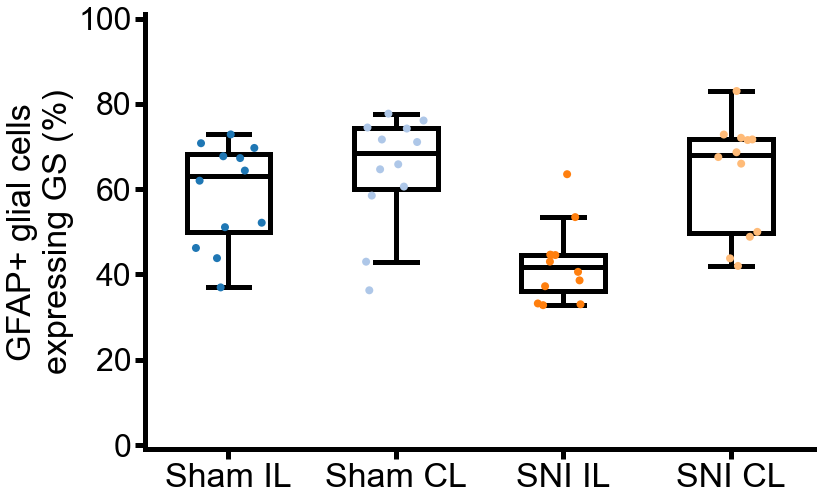

In [25]:
plot_all('gfap_overlaps', 'GFAP+ glial cells\nexpressing GS (%)')

In [26]:
statistic_all('gfap_overlaps')

Mann Whitney U: p-value=0.00101


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.1939,0.0035,0.3708
Sham_CL,0.1939,1.0000,0.0017,0.8399
SNI_IL,0.0035,0.0017,1.0000,0.0011
SNI_CL,0.3708,0.8399,0.0011,1.0000


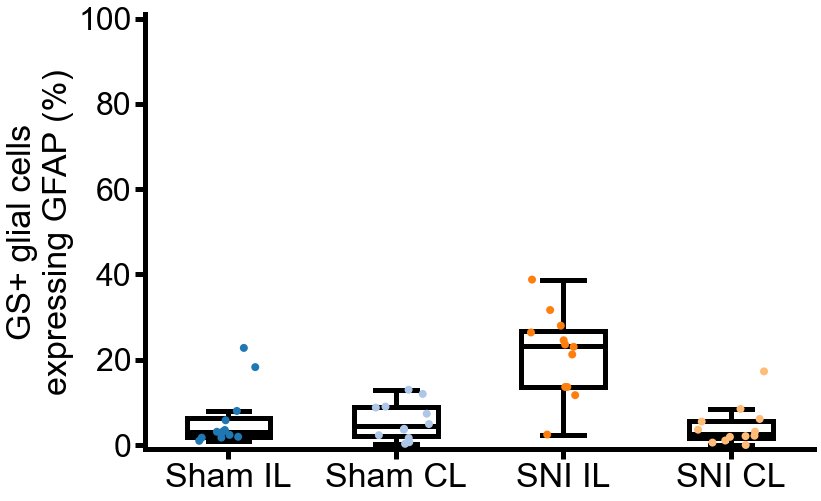

In [27]:
plot_all('gs_overlaps', 'GS+ glial cells\nexpressing GFAP (%)')

In [28]:
statistic_all('gs_overlaps')

Mann Whitney U: p-value=0.00021


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7508,0.0009,0.6236
Sham_CL,0.7508,1.0000,0.0004,0.3123
SNI_IL,0.0009,0.0004,1.0000,0.0003
SNI_CL,0.6236,0.3123,0.0003,1.0000


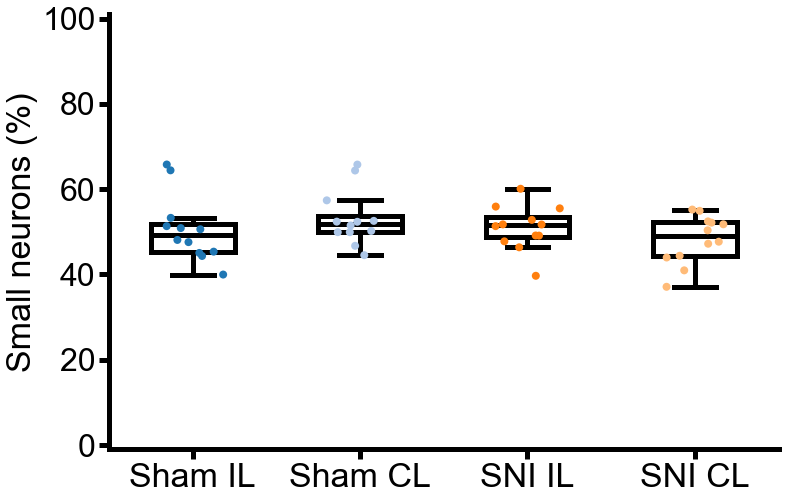

In [29]:
plot_all('small_neurons_percentage', 'Small neurons (%)')

In [30]:
statistic_all('small_neurons_percentage')

one-way ANOVA: p-value=0.30928


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.3835,0.8901,0.3999
Sham_CL,0.3835,1.0000,0.3664,0.0578
SNI_IL,0.8901,0.3664,1.0000,0.2293
SNI_CL,0.3999,0.0578,0.2293,1.0000


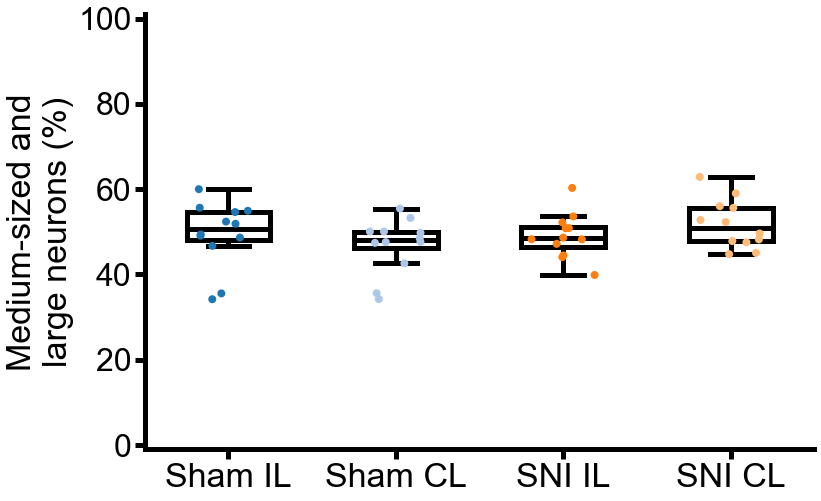

In [31]:
plot_all('bigger_neurons_percentage', 'Medium-sized and\nlarge neurons (%)')

In [32]:
statistic_all('bigger_neurons_percentage')

one-way ANOVA: p-value=0.30928


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.3835,0.8901,0.3999
Sham_CL,0.3835,1.0000,0.3664,0.0578
SNI_IL,0.8901,0.3664,1.0000,0.2293
SNI_CL,0.3999,0.0578,0.2293,1.0000


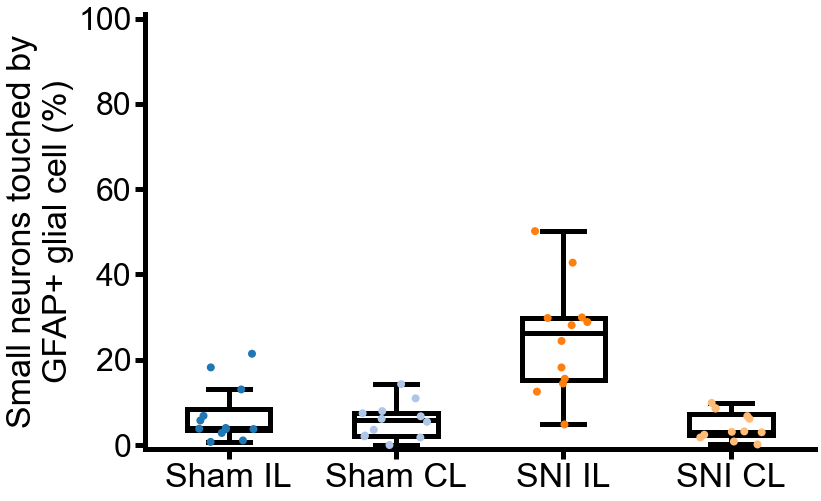

In [33]:
plot_all('small_neurons_gfap_ring', 'Small neurons touched by\nGFAP+ glial cell (%)')

In [34]:
statistic_all('small_neurons_gfap_ring')

Mann Whitney U: p-value=0.00012


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8852,0.0009,0.4025
Sham_CL,0.8852,1.0000,0.0002,0.6650
SNI_IL,0.0009,0.0002,1.0000,0.0001
SNI_CL,0.4025,0.6650,0.0001,1.0000


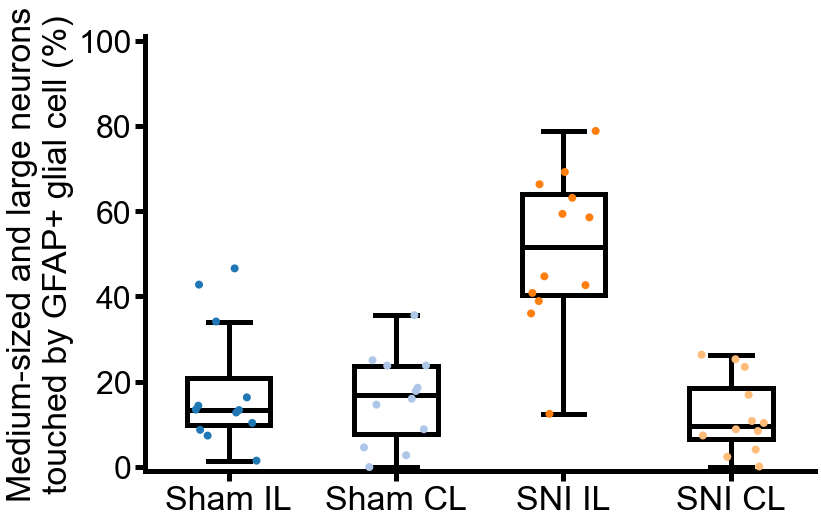

In [35]:
plot_all('bigger_neurons_gfap_ring', 'Medium-sized and large neurons\ntouched by GFAP+ glial cell (%)')

In [36]:
statistic_all('bigger_neurons_gfap_ring')

Mann Whitney U: p-value=0.00011


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8399,0.0017,0.2855
Sham_CL,0.8399,1.0000,0.0002,0.4025
SNI_IL,0.0017,0.0002,1.0000,0.0001
SNI_CL,0.2855,0.4025,0.0001,1.0000


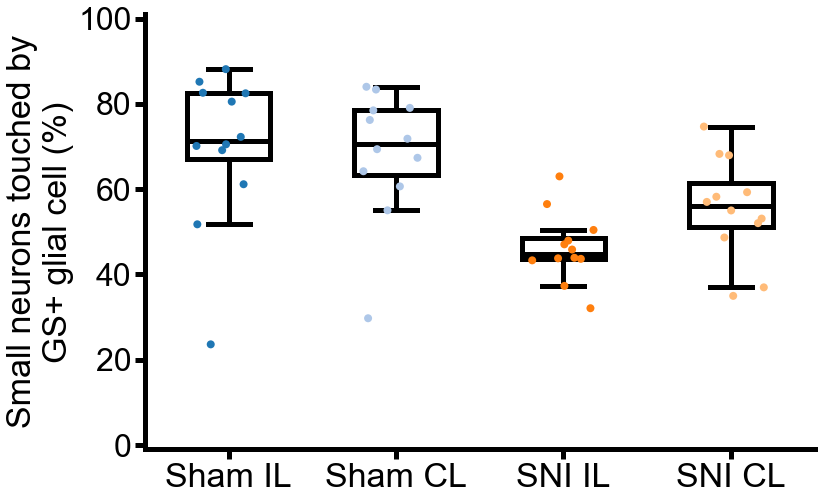

In [37]:
plot_all('small_neurons_gs_ring', 'Small neurons touched by\nGS+ glial cell (%)')

In [38]:
statistic_all('small_neurons_gs_ring')

Mann Whitney U: p-value=0.00021


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5834,0.0011,0.0120
Sham_CL,0.5834,1.0000,0.0011,0.0141
SNI_IL,0.0011,0.0011,1.0000,0.0304
SNI_CL,0.0120,0.0141,0.0304,1.0000


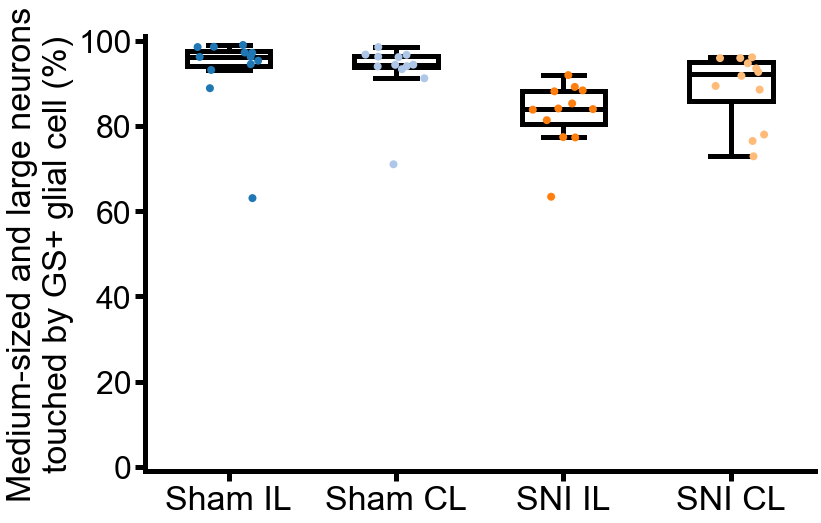

In [39]:
plot_all('bigger_neurons_gs_ring', 'Medium-sized and large neurons\ntouched by GS+ glial cell (%)')

In [40]:
statistic_all('bigger_neurons_gs_ring')

Mann Whitney U: p-value=0.00030


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.2855,0.0009,0.0226
Sham_CL,0.2855,1.0000,0.0006,0.0690
SNI_IL,0.0009,0.0006,1.0000,0.0351
SNI_CL,0.0226,0.0690,0.0351,1.0000


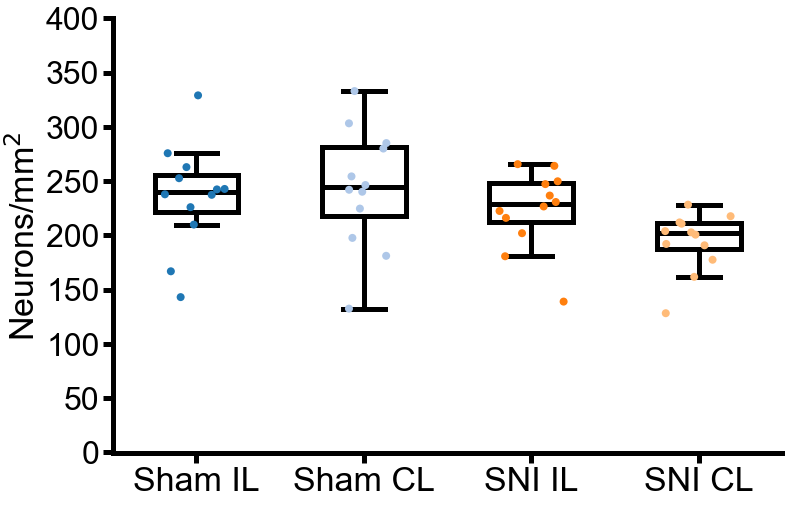

In [41]:
plot_all('neurons_per_tissue', 'Neurons/mm$^2$')

In [42]:
statistic_all('neurons_per_tissue')

one-way ANOVA: p-value=0.03815


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7153,0.4930,0.0161
Sham_CL,0.7153,1.0000,0.3065,0.0108
SNI_IL,0.4930,0.3065,1.0000,0.0342
SNI_CL,0.0161,0.0108,0.0342,1.0000


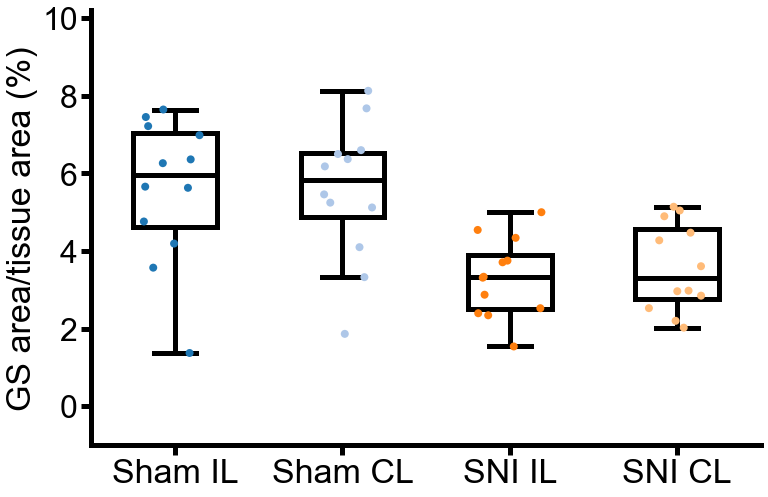

In [43]:
plot_all('gs_area_per_tissue', 'GS area/tissue area (%)')

In [44]:
statistic_all('gs_area_per_tissue')

one-way ANOVA: p-value=0.00021


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9523,0.0011,0.0041
Sham_CL,0.9523,1.0000,0.0011,0.0040
SNI_IL,0.0011,0.0011,1.0000,0.5394
SNI_CL,0.0041,0.0040,0.5394,1.0000


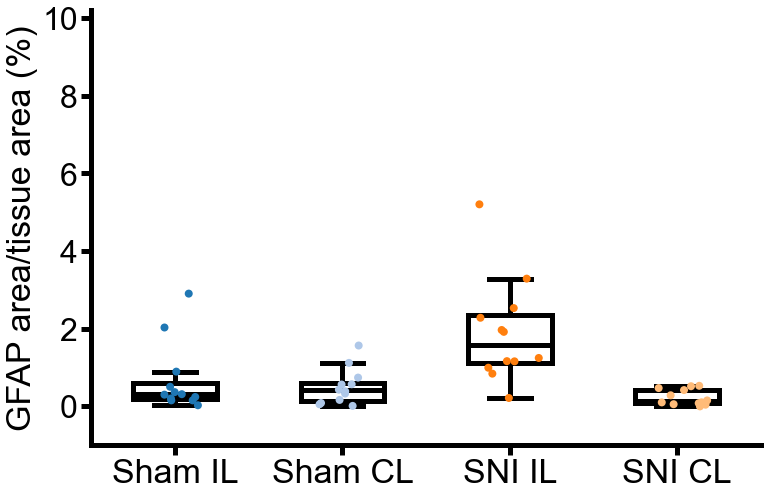

In [45]:
plot_all('gfap_area_per_tissue', 'GFAP area/tissue area (%)')

In [46]:
statistic_all('gfap_area_per_tissue')

Mann Whitney U: p-value=0.00025


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8852,0.0073,0.1260
Sham_CL,0.8852,1.0000,0.0011,0.1260
SNI_IL,0.0073,0.0011,1.0000,0.0001
SNI_CL,0.1260,0.1260,0.0001,1.0000


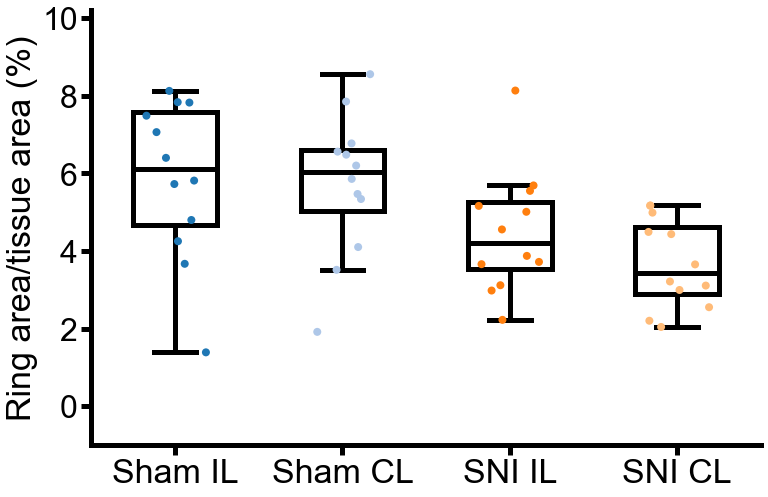

In [47]:
plot_all('ring_area_per_tissue', 'Ring area/tissue area (%)')

In [48]:
statistic_all('ring_area_per_tissue')

one-way ANOVA: p-value=0.00670


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8548,0.0752,0.0037
Sham_CL,0.8548,1.0000,0.0896,0.0035
SNI_IL,0.0752,0.0896,1.0000,0.1681
SNI_CL,0.0037,0.0035,0.1681,1.0000


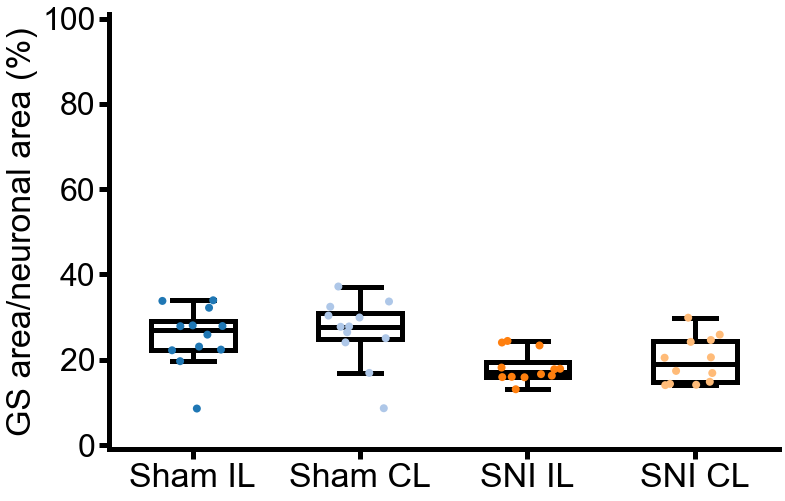

In [49]:
plot_all('gs_area_per_neurons', 'GS area/neuronal area (%)')

In [50]:
statistic_all('gs_area_per_neurons')

Mann Whitney U: p-value=0.00211


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.6650,0.0061,0.0304
Sham_CL,0.6650,1.0000,0.0024,0.0120
SNI_IL,0.0061,0.0024,1.0000,0.6236
SNI_CL,0.0304,0.0120,0.6236,1.0000


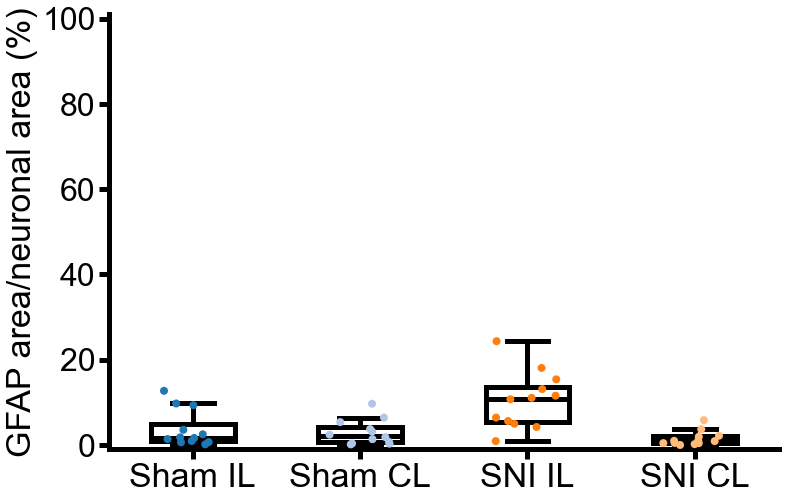

In [51]:
plot_all('gfap_area_per_neurons', 'GFAP area/neuronal area (%)')

In [52]:
statistic_all('gfap_area_per_neurons')

Mann Whitney U: p-value=0.00068


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8399,0.0061,0.1572
Sham_CL,0.8399,1.0000,0.0020,0.2602
SNI_IL,0.0061,0.0020,1.0000,0.0004
SNI_CL,0.1572,0.2602,0.0004,1.0000


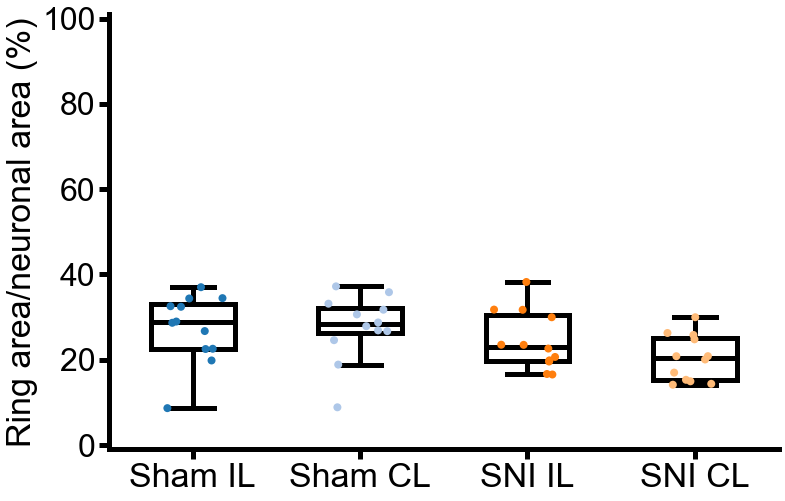

In [53]:
plot_all('ring_area_per_neurons', 'Ring area/neuronal area (%)')

In [54]:
statistic_all('ring_area_per_neurons')

one-way ANOVA: p-value=0.05432


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9521,0.3591,0.0191
Sham_CL,0.9521,1.0000,0.3188,0.0143
SNI_IL,0.3591,0.3188,1.0000,0.1092
SNI_CL,0.0191,0.0143,0.1092,1.0000
